trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model. 

In [1]:

#library import required 
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import torch.optim as optim 

Understanding the difference between the data set provided by google colab and the one downloaded from torchvision datasets

In [2]:
#using the sample data provided with google colab
import pandas as pd
mnist_train_df = pd.read_csv('/content/sample_data/mnist_train_small.csv')
mnist_test_df = pd.read_csv('/content/sample_data/mnist_test.csv')




In [3]:
mnist_train_df.shape


(19999, 785)

In [4]:
#converting the dataframe to tensor

mnist_train_t = torch.Tensor(mnist_train_df.values)
mnist_train_t

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [7., 0., 0.,  ..., 0., 0., 0.],
        [9., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [2., 0., 0.,  ..., 0., 0., 0.],
        [9., 0., 0.,  ..., 0., 0., 0.],
        [5., 0., 0.,  ..., 0., 0., 0.]])

There's some dimension difference between them so I'll stick with the one from tensorvision dataset as I might need more than just 20k observation/images for the learning curve question


In [5]:
#downloading and using the dataset provided by pytorch dataset libraries
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_list)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Understanding the dataset

In [6]:
#the first index below is the index of observation and second one is pixel data and its corresponding label. Understood that after some trials 
#mnist_trainset[0][0]
#mnist_trainset[1][0]
#mnist_trainset[0][1]
# print(mnist_trainset[4][1])
# plt.imshow((mnist_trainset[4][0].view(28,28).numpy()))

Creating a smaller training set to test the initial model

In [7]:
mnist_trainset_small =  [ mnist_trainset[i] for i in range(0,4000) ]

Downloading the testset

In [8]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_list)

**Defining the baseline Neural Network Model**

In [9]:
# Baseline model with linear fully connected network and functionality to add dropout rate
#default activation function set to sigmoid and dropout rate to 0 making no difference to the NN

class BaselineModel(nn.Module):
    def __init__(self,act_fn=nn.Sigmoid(),dropout_rate=0):
        super(BaselineModel, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 1000),
        act_fn,
        nn.Dropout(dropout_rate),
        #nn.Sigmoid(),
        nn.Linear(1000, 784),
        act_fn,
        #nn.Sigmoid(),
        nn.Linear(784, 10)
        
       )
    def forward(self, x):
      x =  self.layers(x)
      return x
   

**Training model Function**

In [10]:
def train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model, batch_size):
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
  train_model.loss_error_list = []
  for epoch in tqdm(range(n_epochs)):
    curr_loss = 0.0
    no_mini_batch=0

    for mini_batch in trainloader:
      images,labels = mini_batch

      optimizer.zero_grad()

      output= model(images)
      loss = loss_fnc(output,labels)
      loss.backward()
      optimizer.step()

      no_mini_batch +=1
      curr_loss += loss.item() 
    loss_rate = curr_loss / no_mini_batch
    print('Epoch %d loss: %.3f' %(epoch+1, loss_rate))
    train_model.loss_error_list.append(loss_rate)





**Providing the hyper-parameter and training the model**

In [11]:
#hyperparam

lr=0.001
# I kept the epoch value to 20 cause I was getting low training loss too early and to reduce the training time. This may be due to the increased complexity of 
# the neural network as compared to just one single hidden layer that might need more than just 20 epochs
# I first tried 30 epoch but after 20+, the error rate stays constant and start increasing at the very end i.e. near 30
n_epochs=20
loss_fnc = nn.CrossEntropyLoss() 
batch_size = 32
#drop_rate = 0
#act_fn = nn.Sigmoid()

model = BaselineModel()
optimizer = optim.Adam(params=model.parameters(), lr=lr) 


train_model(mnist_trainset_small, n_epochs, lr, optimizer, loss_fnc, model, batch_size)


Epoch 1 loss: 1.304
Epoch 2 loss: 0.407
Epoch 3 loss: 0.287
Epoch 4 loss: 0.238
Epoch 5 loss: 0.197
Epoch 6 loss: 0.164
Epoch 7 loss: 0.141
Epoch 8 loss: 0.110
Epoch 9 loss: 0.098
Epoch 10 loss: 0.073
Epoch 11 loss: 0.058
Epoch 12 loss: 0.044
Epoch 13 loss: 0.038
Epoch 14 loss: 0.029
Epoch 15 loss: 0.019
Epoch 16 loss: 0.016
Epoch 17 loss: 0.017
Epoch 18 loss: 0.020
Epoch 19 loss: 0.009
Epoch 20 loss: 0.006



**Graph of training epoch vs error_rate**

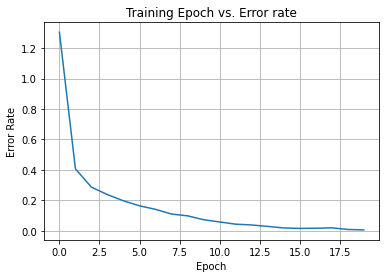

In [12]:
plt.plot(range(n_epochs),train_model.loss_error_list)
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Training Epoch vs. Error rate')
plt.grid()

**Evaluating the trained model on the validation/dev set function**

In [13]:

def evaluate_trained_model(model, dev_data,b_size):
  testloader = torch.utils.data.DataLoader( dev_data, batch_size=b_size, shuffle=True)
  correct = 0 
  total = 0 
  with torch.no_grad():  
      for mini_batch in tqdm(testloader): 
          images, labels = mini_batch
          outputs = model(images)
          _, predicted = torch.max( outputs, dim=1)
          total += labels.size(0) # the number of labels, which is just the size of the batch 
          correct += (predicted == labels).sum().item() # once again, note that the sum is a zero-dimensional tensor, 
                                                        # so we must access its value using .item()

  evaluate_trained_model.error_rate = (1- correct/total)                                                    
  print( "Accuracy on test set: %.2f %%" %(100 * correct/total))
  print( "error rate on test set: %.3f " %evaluate_trained_model.error_rate)


Evaluating the trained model on dev set


In [14]:
evaluate_trained_model(model,mnist_testset,batch_size)


Accuracy on test set: 92.88 %
error rate on test set: 0.071 


### 2.  Regularisation experiment:  


A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse. 

**Training the model with different values of L2 parameter i.e. weight_decay**

In [15]:
# your code here 
#hyperparameters 
n_epochs = 20
lr=0.001
act_fn = nn.Sigmoid()
dropout_rate =0
#weight_decay parameter to optimizer act as l2 regularization. trying different values of the penalty while training the model
l2_reg = [0,1e-5,1e-4,1e-3]
model_list = []
for reg in tqdm(l2_reg):
  model = BaselineModel(act_fn,dropout_rate)
  optimizer = optim.Adam(params=model.parameters(), lr=lr,weight_decay=reg)
  #Adam was working fine but the graph was too skewed and hence I thought of trying different optimizers with same l2 weight_decay value 
  #optimizer = optim.SGD(params=model.parameters(), lr=lr,weight_decay=reg) 
  # Tried using SGD and realised that it might take a lot of epoch for better performance
  #optimizer = optim.RMSprop(params=model.parameters(), lr=lr,weight_decay=reg)
  #moving back to Adam as I dont see significant differences between RMSprop and Adam
  train_model(mnist_trainset_small, n_epochs, lr, optimizer, loss_fnc, model, batch_size)
  model_list.append(model)


Epoch 1 loss: 1.330
Epoch 2 loss: 0.409
Epoch 3 loss: 0.292
Epoch 4 loss: 0.241
Epoch 5 loss: 0.200
Epoch 6 loss: 0.158
Epoch 7 loss: 0.130
Epoch 8 loss: 0.110
Epoch 9 loss: 0.095
Epoch 10 loss: 0.072
Epoch 11 loss: 0.054
Epoch 12 loss: 0.047
Epoch 13 loss: 0.035
Epoch 14 loss: 0.024
Epoch 15 loss: 0.020
Epoch 16 loss: 0.016
Epoch 17 loss: 0.012
Epoch 18 loss: 0.008
Epoch 19 loss: 0.006
Epoch 20 loss: 0.005



Epoch 1 loss: 1.278
Epoch 2 loss: 0.394
Epoch 3 loss: 0.299
Epoch 4 loss: 0.238
Epoch 5 loss: 0.189
Epoch 6 loss: 0.165
Epoch 7 loss: 0.142
Epoch 8 loss: 0.109
Epoch 9 loss: 0.096
Epoch 10 loss: 0.073
Epoch 11 loss: 0.068
Epoch 12 loss: 0.050
Epoch 13 loss: 0.040
Epoch 14 loss: 0.035
Epoch 15 loss: 0.025
Epoch 16 loss: 0.019
Epoch 17 loss: 0.015
Epoch 18 loss: 0.013
Epoch 19 loss: 0.011
Epoch 20 loss: 0.009



Epoch 1 loss: 1.342
Epoch 2 loss: 0.415
Epoch 3 loss: 0.308
Epoch 4 loss: 0.254
Epoch 5 loss: 0.225
Epoch 6 loss: 0.192
Epoch 7 loss: 0.188
Epoch 8 loss: 0.156
Epoch 9 loss: 0.141
Epoch 10 loss: 0.125
Epoch 11 loss: 0.108
Epoch 12 loss: 0.097
Epoch 13 loss: 0.086
Epoch 14 loss: 0.087
Epoch 15 loss: 0.073
Epoch 16 loss: 0.067
Epoch 17 loss: 0.065
Epoch 18 loss: 0.068
Epoch 19 loss: 0.060
Epoch 20 loss: 0.054



Epoch 1 loss: 1.379
Epoch 2 loss: 0.517
Epoch 3 loss: 0.438
Epoch 4 loss: 0.399
Epoch 5 loss: 0.386
Epoch 6 loss: 0.377
Epoch 7 loss: 0.354
Epoch 8 loss: 0.367
Epoch 9 loss: 0.339
Epoch 10 loss: 0.342
Epoch 11 loss: 0.344
Epoch 12 loss: 0.319
Epoch 13 loss: 0.335
Epoch 14 loss: 0.328
Epoch 15 loss: 0.299
Epoch 16 loss: 0.316
Epoch 17 loss: 0.310
Epoch 18 loss: 0.311
Epoch 19 loss: 0.310
Epoch 20 loss: 0.278




Validating the above models on test set

In [16]:
test_err_rate = []
for model in model_list:
  evaluate_trained_model(model,mnist_testset,batch_size)
  test_err_rate.append(evaluate_trained_model.error_rate)


Accuracy on test set: 92.99 %
error rate on test set: 0.070 



Accuracy on test set: 92.80 %
error rate on test set: 0.072 



Accuracy on test set: 91.65 %
error rate on test set: 0.084 



Accuracy on test set: 88.46 %
error rate on test set: 0.115 


Text(0.5, 1.0, 'Weight Decay vs error rate')

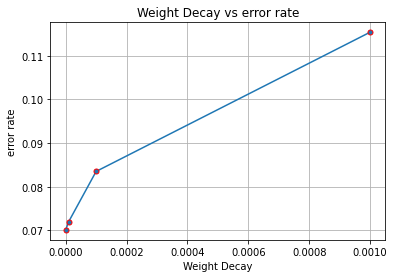

In [17]:
plt.plot(l2_reg,test_err_rate,marker='.',mec='r',ms =10)
plt.grid()
plt.xlabel('Weight Decay')
plt.ylabel('error rate')
plt.title('Weight Decay vs error rate')

How does regularisation affect the performance of your initial network, and what is the optimal amount?

Ans: L2 Regularization penalises the overfitting for training data that might cause bad performance on validation_set. If the penalty value is high we might also face issue of underfitting and might make our model worse by moving the "perfect" weight away. As per the above observation, a small amount of this weight_decay regularization parameter is fine but if we use values that skew the weight calculated too far, that might decrease the performance of model on both the training as well as testing set. In this case, the model is getting better test accuracy with 0 value for weight_decay.

I'm not happy with the L2 regularization here and would like to try dropout regularization as well to see what serves better

**Training the model again with different dropout values**

In [19]:
# your code here 
#hyperparameters 
n_epochs = 20
act_fn = nn.Sigmoid()
#keeping the best weight_decay from last performance graph
weight_decay = 0
#trying different values of dropout_rate
dropout_rate = [0,0.2,0.4,0.5]
model_list = []
for drop in tqdm(dropout_rate):
  model = BaselineModel(act_fn,drop)
  optimizer = optim.Adam(params=model.parameters(), lr=lr,weight_decay=weight_decay) 
  train_model(mnist_trainset_small, n_epochs, lr, optimizer, loss_fnc, model, batch_size)
  model_list.append(model)


Epoch 1 loss: 1.288
Epoch 2 loss: 0.401
Epoch 3 loss: 0.283
Epoch 4 loss: 0.239
Epoch 5 loss: 0.194
Epoch 6 loss: 0.162
Epoch 7 loss: 0.129
Epoch 8 loss: 0.107
Epoch 9 loss: 0.094
Epoch 10 loss: 0.069
Epoch 11 loss: 0.060
Epoch 12 loss: 0.050
Epoch 13 loss: 0.032
Epoch 14 loss: 0.023
Epoch 15 loss: 0.020
Epoch 16 loss: 0.014
Epoch 17 loss: 0.011
Epoch 18 loss: 0.008
Epoch 19 loss: 0.006
Epoch 20 loss: 0.005



Epoch 1 loss: 1.308
Epoch 2 loss: 0.402
Epoch 3 loss: 0.297
Epoch 4 loss: 0.255
Epoch 5 loss: 0.204
Epoch 6 loss: 0.178
Epoch 7 loss: 0.155
Epoch 8 loss: 0.121
Epoch 9 loss: 0.109
Epoch 10 loss: 0.088
Epoch 11 loss: 0.068
Epoch 12 loss: 0.056
Epoch 13 loss: 0.050
Epoch 14 loss: 0.042
Epoch 15 loss: 0.033
Epoch 16 loss: 0.025
Epoch 17 loss: 0.019
Epoch 18 loss: 0.018
Epoch 19 loss: 0.014
Epoch 20 loss: 0.016



Epoch 1 loss: 1.336
Epoch 2 loss: 0.431
Epoch 3 loss: 0.332
Epoch 4 loss: 0.278
Epoch 5 loss: 0.225
Epoch 6 loss: 0.201
Epoch 7 loss: 0.181
Epoch 8 loss: 0.152
Epoch 9 loss: 0.129
Epoch 10 loss: 0.129
Epoch 11 loss: 0.104
Epoch 12 loss: 0.088
Epoch 13 loss: 0.080
Epoch 14 loss: 0.068
Epoch 15 loss: 0.054
Epoch 16 loss: 0.052
Epoch 17 loss: 0.050
Epoch 18 loss: 0.047
Epoch 19 loss: 0.033
Epoch 20 loss: 0.029



Epoch 1 loss: 1.425
Epoch 2 loss: 0.469
Epoch 3 loss: 0.340
Epoch 4 loss: 0.291
Epoch 5 loss: 0.257
Epoch 6 loss: 0.229
Epoch 7 loss: 0.188
Epoch 8 loss: 0.173
Epoch 9 loss: 0.150
Epoch 10 loss: 0.136
Epoch 11 loss: 0.124
Epoch 12 loss: 0.108
Epoch 13 loss: 0.092
Epoch 14 loss: 0.087
Epoch 15 loss: 0.076
Epoch 16 loss: 0.061
Epoch 17 loss: 0.059
Epoch 18 loss: 0.056
Epoch 19 loss: 0.051
Epoch 20 loss: 0.042




In [20]:
test_err_rate = []
for model in model_list:
  evaluate_trained_model(model,mnist_testset,batch_size)
  test_err_rate.append(evaluate_trained_model.error_rate)


Accuracy on test set: 92.96 %
error rate on test set: 0.070 



Accuracy on test set: 91.67 %
error rate on test set: 0.083 



Accuracy on test set: 92.17 %
error rate on test set: 0.078 



Accuracy on test set: 92.53 %
error rate on test set: 0.075 


Text(0.5, 1.0, 'dropout_rate vs error rate')

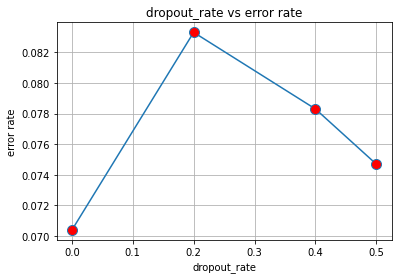

In [21]:
plt.plot(dropout_rate,test_err_rate,marker='o',mfc = 'r',ms =10)
plt.grid()
plt.xlabel('dropout_rate')
plt.ylabel('error rate')
plt.title('dropout_rate vs error rate')

### 3.  Learning curve experiment:

**Making a list of training set with different sizes**

In [22]:
# your code here
train_set_list =[]
size = [500,1000,2000,4000,8000,16000]
for num in size:
  mnist_trainset_sub =  [ mnist_trainset[i] for i in range(0,num) ]
  train_set_list.append(mnist_trainset_sub)



**Training the model with different sizes of training set**

In [23]:
# your code here 
#hyperparameters 
n_epochs = 20
act_fn = nn.Sigmoid()
#weight_decay parameter to optimizer act as l2 regularization. trying different values of the penalty while training the model
#weight_decay = 1e-5
#dropout_rate = 0.2
model_list = []
for training in tqdm(train_set_list):
  model = BaselineModel(act_fn)
  optimizer = optim.Adam(params=model.parameters(), lr=lr) 
  train_model(training, n_epochs, lr, optimizer, loss_fnc, model, batch_size)
  model_list.append(model)

Epoch 1 loss: 2.412
Epoch 2 loss: 2.112
Epoch 3 loss: 1.631
Epoch 4 loss: 1.083
Epoch 5 loss: 0.736
Epoch 6 loss: 0.567
Epoch 7 loss: 0.440
Epoch 8 loss: 0.339
Epoch 9 loss: 0.270
Epoch 10 loss: 0.211
Epoch 11 loss: 0.175
Epoch 12 loss: 0.148
Epoch 13 loss: 0.119
Epoch 14 loss: 0.104
Epoch 15 loss: 0.079
Epoch 16 loss: 0.069
Epoch 17 loss: 0.057
Epoch 18 loss: 0.047
Epoch 19 loss: 0.036
Epoch 20 loss: 0.031



Epoch 1 loss: 2.328
Epoch 2 loss: 1.548
Epoch 3 loss: 0.840
Epoch 4 loss: 0.575
Epoch 5 loss: 0.430
Epoch 6 loss: 0.319
Epoch 7 loss: 0.247
Epoch 8 loss: 0.219
Epoch 9 loss: 0.185
Epoch 10 loss: 0.150
Epoch 11 loss: 0.133
Epoch 12 loss: 0.115
Epoch 13 loss: 0.095
Epoch 14 loss: 0.073
Epoch 15 loss: 0.063
Epoch 16 loss: 0.053
Epoch 17 loss: 0.040
Epoch 18 loss: 0.035
Epoch 19 loss: 0.028
Epoch 20 loss: 0.025



Epoch 1 loss: 1.918
Epoch 2 loss: 0.737
Epoch 3 loss: 0.449
Epoch 4 loss: 0.334
Epoch 5 loss: 0.262
Epoch 6 loss: 0.224
Epoch 7 loss: 0.198
Epoch 8 loss: 0.176
Epoch 9 loss: 0.144
Epoch 10 loss: 0.116
Epoch 11 loss: 0.099
Epoch 12 loss: 0.085
Epoch 13 loss: 0.078
Epoch 14 loss: 0.054
Epoch 15 loss: 0.052
Epoch 16 loss: 0.034
Epoch 17 loss: 0.027
Epoch 18 loss: 0.021
Epoch 19 loss: 0.017
Epoch 20 loss: 0.015



Epoch 1 loss: 1.316
Epoch 2 loss: 0.409
Epoch 3 loss: 0.292
Epoch 4 loss: 0.239
Epoch 5 loss: 0.201
Epoch 6 loss: 0.168
Epoch 7 loss: 0.131
Epoch 8 loss: 0.108
Epoch 9 loss: 0.094
Epoch 10 loss: 0.072
Epoch 11 loss: 0.062
Epoch 12 loss: 0.048
Epoch 13 loss: 0.036
Epoch 14 loss: 0.024
Epoch 15 loss: 0.023
Epoch 16 loss: 0.022
Epoch 17 loss: 0.015
Epoch 18 loss: 0.010
Epoch 19 loss: 0.006
Epoch 20 loss: 0.005



Epoch 1 loss: 0.873
Epoch 2 loss: 0.303
Epoch 3 loss: 0.238
Epoch 4 loss: 0.182
Epoch 5 loss: 0.148
Epoch 6 loss: 0.116
Epoch 7 loss: 0.096
Epoch 8 loss: 0.084
Epoch 9 loss: 0.060
Epoch 10 loss: 0.048
Epoch 11 loss: 0.036
Epoch 12 loss: 0.027
Epoch 13 loss: 0.020
Epoch 14 loss: 0.016
Epoch 15 loss: 0.010
Epoch 16 loss: 0.008
Epoch 17 loss: 0.005
Epoch 18 loss: 0.004
Epoch 19 loss: 0.008
Epoch 20 loss: 0.039



Epoch 1 loss: 0.614
Epoch 2 loss: 0.242
Epoch 3 loss: 0.175
Epoch 4 loss: 0.129
Epoch 5 loss: 0.097
Epoch 6 loss: 0.071
Epoch 7 loss: 0.055
Epoch 8 loss: 0.040
Epoch 9 loss: 0.029
Epoch 10 loss: 0.022
Epoch 11 loss: 0.020
Epoch 12 loss: 0.017
Epoch 13 loss: 0.011
Epoch 14 loss: 0.015
Epoch 15 loss: 0.009
Epoch 16 loss: 0.018
Epoch 17 loss: 0.002
Epoch 18 loss: 0.001
Epoch 19 loss: 0.000
Epoch 20 loss: 0.000




**Validation set**

In [24]:
test_err_rate = []
for model in model_list:
  evaluate_trained_model(model,mnist_testset,batch_size)
  test_err_rate.append(evaluate_trained_model.error_rate)


Accuracy on test set: 84.46 %
error rate on test set: 0.155 



Accuracy on test set: 87.13 %
error rate on test set: 0.129 



Accuracy on test set: 90.19 %
error rate on test set: 0.098 



Accuracy on test set: 92.99 %
error rate on test set: 0.070 



Accuracy on test set: 94.55 %
error rate on test set: 0.054 



Accuracy on test set: 97.05 %
error rate on test set: 0.029 


Plotting the log log of training size and error rate.

Text(0.5, 1.0, 'log log training size vs. error rate')

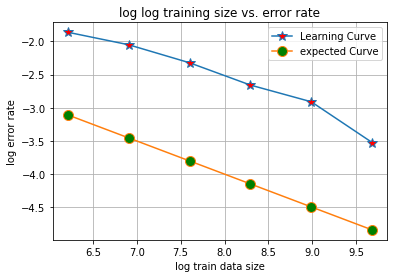

In [25]:
from math import log
from math import sqrt
size_log = [log(x) for x in size]
err_log_vnn = [log(x) for x in test_err_rate]
appr_log = [log(1/sqrt(x)) for x in size]
plt.plot(size_log,err_log_vnn,marker='*',mfc = 'r',ms =10, label = 'Learning Curve')
plt.plot(size_log,appr_log,marker='o',mfc = 'g',ms =10, label = 'expected Curve' )
plt.grid()
plt.legend()
plt.xlabel('log train data size')
plt.ylabel('log error rate')
plt.title('log log training size vs. error rate')

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ? 

Ans:
Training set size and loss/error-rate are inversely proportional to each other. As we increase our training set size, the loss tends to decrease on validation set and this intuitively makes sense as we are training our models with more examples and thus our model might become better at classifying them based of the different training samples. The performance of network does increase by power of $\sqrt{n}$ where n is the size of training set.  

### 4. Second model: 

In [26]:
# your code here
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self,dropout=False):
        self.dropout = dropout
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        if self.dropout==True:
          self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        if self.dropout==True:
          x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        else:
          x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        if self.dropout==True:
          x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x)
        return x


In [27]:
#hyperparam

lr=0.001
n_epochs=20
loss_fnc = nn.CrossEntropyLoss() 
batch_size = 32
#drop_rate = 0
#act_fn = nn.Sigmoid()

model = Net()
#model= Net(dropout=True)
import torch.optim as optim 
optimizer = optim.Adam(params=model.parameters(), lr=lr) 


train_model(mnist_trainset_small, n_epochs, lr, optimizer, loss_fnc, model, batch_size)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 loss: 1.182
Epoch 2 loss: 0.354
Epoch 3 loss: 0.239
Epoch 4 loss: 0.193
Epoch 5 loss: 0.164
Epoch 6 loss: 0.126
Epoch 7 loss: 0.114
Epoch 8 loss: 0.103
Epoch 9 loss: 0.096
Epoch 10 loss: 0.084
Epoch 11 loss: 0.071
Epoch 12 loss: 0.062
Epoch 13 loss: 0.062
Epoch 14 loss: 0.049
Epoch 15 loss: 0.045
Epoch 16 loss: 0.047
Epoch 17 loss: 0.046
Epoch 18 loss: 0.039
Epoch 19 loss: 0.026
Epoch 20 loss: 0.023



In [28]:
evaluate_trained_model(model,mnist_testset,batch_size)



Accuracy on test set: 97.22 %
error rate on test set: 0.028 


Training with different weight decay

In [29]:
# your code here 
#hyperparameters 
import torch.optim as optim 
lr = 0.001
loss_fnc = nn.CrossEntropyLoss()
batch_size=32
n_epochs = 20
act_fn = nn.Sigmoid()
#weight_decay parameter to optimizer act as l2 regularization. trying different values of the penalty while training the model
l2_reg = [0,1e-5,1e-4,1e-3]
model_list = []
for reg in tqdm(l2_reg):
  model = Net()
  optimizer = optim.Adam(params=model.parameters(), lr=lr,weight_decay=reg) 
  #optimizer = optim.SGD(params=model.parameters(), lr=lr,weight_decay=reg) 
  # Tried using SGD and realised that it might take a lot of epoch for better performance
  train_model(mnist_trainset_small, n_epochs, lr, optimizer, loss_fnc, model, batch_size)
  model_list.append(model)


Epoch 1 loss: 1.145
Epoch 2 loss: 0.339
Epoch 3 loss: 0.234
Epoch 4 loss: 0.174
Epoch 5 loss: 0.140
Epoch 6 loss: 0.116
Epoch 7 loss: 0.099
Epoch 8 loss: 0.083
Epoch 9 loss: 0.079
Epoch 10 loss: 0.063
Epoch 11 loss: 0.055
Epoch 12 loss: 0.048
Epoch 13 loss: 0.049
Epoch 14 loss: 0.037
Epoch 15 loss: 0.039
Epoch 16 loss: 0.026
Epoch 17 loss: 0.022
Epoch 18 loss: 0.016
Epoch 19 loss: 0.019
Epoch 20 loss: 0.020



Epoch 1 loss: 1.104
Epoch 2 loss: 0.314
Epoch 3 loss: 0.209
Epoch 4 loss: 0.152
Epoch 5 loss: 0.122
Epoch 6 loss: 0.103
Epoch 7 loss: 0.090
Epoch 8 loss: 0.076
Epoch 9 loss: 0.066
Epoch 10 loss: 0.061
Epoch 11 loss: 0.049
Epoch 12 loss: 0.050
Epoch 13 loss: 0.044
Epoch 14 loss: 0.039
Epoch 15 loss: 0.027
Epoch 16 loss: 0.025
Epoch 17 loss: 0.024
Epoch 18 loss: 0.016
Epoch 19 loss: 0.015
Epoch 20 loss: 0.015



Epoch 1 loss: 1.094
Epoch 2 loss: 0.305
Epoch 3 loss: 0.203
Epoch 4 loss: 0.153
Epoch 5 loss: 0.119
Epoch 6 loss: 0.096
Epoch 7 loss: 0.086
Epoch 8 loss: 0.078
Epoch 9 loss: 0.063
Epoch 10 loss: 0.053
Epoch 11 loss: 0.046
Epoch 12 loss: 0.037
Epoch 13 loss: 0.031
Epoch 14 loss: 0.030
Epoch 15 loss: 0.027
Epoch 16 loss: 0.024
Epoch 17 loss: 0.018
Epoch 18 loss: 0.011
Epoch 19 loss: 0.009
Epoch 20 loss: 0.008



Epoch 1 loss: 1.103
Epoch 2 loss: 0.332
Epoch 3 loss: 0.216
Epoch 4 loss: 0.158
Epoch 5 loss: 0.130
Epoch 6 loss: 0.106
Epoch 7 loss: 0.096
Epoch 8 loss: 0.081
Epoch 9 loss: 0.073
Epoch 10 loss: 0.062
Epoch 11 loss: 0.058
Epoch 12 loss: 0.046
Epoch 13 loss: 0.041
Epoch 14 loss: 0.034
Epoch 15 loss: 0.035
Epoch 16 loss: 0.034
Epoch 17 loss: 0.027
Epoch 18 loss: 0.022
Epoch 19 loss: 0.024
Epoch 20 loss: 0.018




In [30]:
test_err_rate = []
for model in model_list:
  evaluate_trained_model(model,mnist_testset,batch_size)
  test_err_rate.append(evaluate_trained_model.error_rate)


Accuracy on test set: 96.92 %
error rate on test set: 0.031 



Accuracy on test set: 97.07 %
error rate on test set: 0.029 



Accuracy on test set: 96.82 %
error rate on test set: 0.032 



Accuracy on test set: 96.87 %
error rate on test set: 0.031 


Text(0.5, 1.0, 'Weight Decay vs error rate')

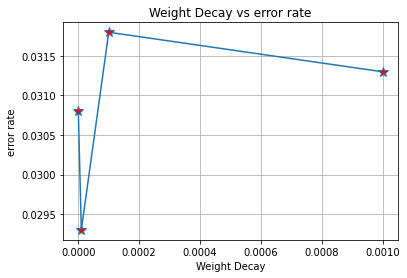

In [31]:
plt.plot(l2_reg,test_err_rate,marker='*',mfc = 'r',ms =10)
plt.grid()
plt.xlabel('Weight Decay')
plt.ylabel('error rate')
plt.title('Weight Decay vs error rate')


This CNN performs better than the first model with higher accuracy on the training size of 4000

With different Size of training set and using the best weight_decay parameter 1e-5


In [32]:
# your code here 
#hyperparameters 
n_epochs = 20
act_fn = nn.Sigmoid()
weight_decay=1e-5

model_list = []
for training in tqdm(train_set_list):
  model = Net()
  optimizer = optim.Adam(params=model.parameters(), lr=lr,weight_decay=weight_decay) 
  train_model(training, n_epochs, lr, optimizer, loss_fnc, model, batch_size)
  model_list.append(model)

Epoch 1 loss: 2.263
Epoch 2 loss: 1.967
Epoch 3 loss: 1.302
Epoch 4 loss: 0.767
Epoch 5 loss: 0.581
Epoch 6 loss: 0.430
Epoch 7 loss: 0.371
Epoch 8 loss: 0.298
Epoch 9 loss: 0.254
Epoch 10 loss: 0.207
Epoch 11 loss: 0.182
Epoch 12 loss: 0.154
Epoch 13 loss: 0.141
Epoch 14 loss: 0.136
Epoch 15 loss: 0.107
Epoch 16 loss: 0.102
Epoch 17 loss: 0.081
Epoch 18 loss: 0.068
Epoch 19 loss: 0.059
Epoch 20 loss: 0.046



Epoch 1 loss: 2.209
Epoch 2 loss: 1.385
Epoch 3 loss: 0.703
Epoch 4 loss: 0.503
Epoch 5 loss: 0.368
Epoch 6 loss: 0.331
Epoch 7 loss: 0.282
Epoch 8 loss: 0.229
Epoch 9 loss: 0.199
Epoch 10 loss: 0.187
Epoch 11 loss: 0.170
Epoch 12 loss: 0.155
Epoch 13 loss: 0.154
Epoch 14 loss: 0.132
Epoch 15 loss: 0.101
Epoch 16 loss: 0.087
Epoch 17 loss: 0.073
Epoch 18 loss: 0.071
Epoch 19 loss: 0.064
Epoch 20 loss: 0.052



Epoch 1 loss: 1.744
Epoch 2 loss: 0.581
Epoch 3 loss: 0.415
Epoch 4 loss: 0.293
Epoch 5 loss: 0.243
Epoch 6 loss: 0.195
Epoch 7 loss: 0.173
Epoch 8 loss: 0.138
Epoch 9 loss: 0.127
Epoch 10 loss: 0.095
Epoch 11 loss: 0.081
Epoch 12 loss: 0.072
Epoch 13 loss: 0.067
Epoch 14 loss: 0.056
Epoch 15 loss: 0.042
Epoch 16 loss: 0.043
Epoch 17 loss: 0.032
Epoch 18 loss: 0.033
Epoch 19 loss: 0.034
Epoch 20 loss: 0.021



Epoch 1 loss: 1.104
Epoch 2 loss: 0.307
Epoch 3 loss: 0.220
Epoch 4 loss: 0.168
Epoch 5 loss: 0.129
Epoch 6 loss: 0.112
Epoch 7 loss: 0.093
Epoch 8 loss: 0.085
Epoch 9 loss: 0.072
Epoch 10 loss: 0.060
Epoch 11 loss: 0.056
Epoch 12 loss: 0.046
Epoch 13 loss: 0.041
Epoch 14 loss: 0.039
Epoch 15 loss: 0.028
Epoch 16 loss: 0.032
Epoch 17 loss: 0.026
Epoch 18 loss: 0.030
Epoch 19 loss: 0.012
Epoch 20 loss: 0.010



Epoch 1 loss: 0.733
Epoch 2 loss: 0.197
Epoch 3 loss: 0.138
Epoch 4 loss: 0.103
Epoch 5 loss: 0.083
Epoch 6 loss: 0.070
Epoch 7 loss: 0.059
Epoch 8 loss: 0.054
Epoch 9 loss: 0.041
Epoch 10 loss: 0.035
Epoch 11 loss: 0.034
Epoch 12 loss: 0.025
Epoch 13 loss: 0.022
Epoch 14 loss: 0.022
Epoch 15 loss: 0.018
Epoch 16 loss: 0.019
Epoch 17 loss: 0.013
Epoch 18 loss: 0.009
Epoch 19 loss: 0.005
Epoch 20 loss: 0.014



Epoch 1 loss: 0.526
Epoch 2 loss: 0.158
Epoch 3 loss: 0.103
Epoch 4 loss: 0.083
Epoch 5 loss: 0.067
Epoch 6 loss: 0.056
Epoch 7 loss: 0.048
Epoch 8 loss: 0.042
Epoch 9 loss: 0.037
Epoch 10 loss: 0.031
Epoch 11 loss: 0.027
Epoch 12 loss: 0.026
Epoch 13 loss: 0.023
Epoch 14 loss: 0.017
Epoch 15 loss: 0.018
Epoch 16 loss: 0.013
Epoch 17 loss: 0.017
Epoch 18 loss: 0.011
Epoch 19 loss: 0.015
Epoch 20 loss: 0.011




In [33]:
test_err_rate = []
for model in model_list:
  evaluate_trained_model(model,mnist_testset,batch_size)
  test_err_rate.append(evaluate_trained_model.error_rate)


Accuracy on test set: 89.57 %
error rate on test set: 0.104 



Accuracy on test set: 92.96 %
error rate on test set: 0.070 



Accuracy on test set: 95.36 %
error rate on test set: 0.046 



Accuracy on test set: 97.01 %
error rate on test set: 0.030 



Accuracy on test set: 97.08 %
error rate on test set: 0.029 



Accuracy on test set: 98.37 %
error rate on test set: 0.016 


Text(0.5, 1.0, 'log log training size vs. error rate')

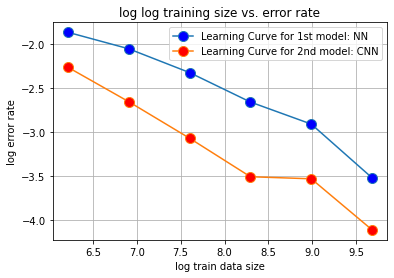

In [35]:
from math import log
from math import sqrt
size_log = [log(x) for x in size]
err_log_cnn = [log(x) for x in test_err_rate]
#appr_log = [log(1/sqrt(x)) for x in size]
plt.plot(size_log,err_log_vnn,marker='o',mfc = 'b',ms =10, label = 'Learning Curve for 1st model: NN')
plt.plot(size_log,err_log_cnn,marker='o',mfc = 'r',ms =10, label = 'Learning Curve for 2nd model: CNN' )
plt.grid()
plt.legend()
plt.xlabel('log train data size')
plt.ylabel('log error rate')
plt.title('log log training size vs. error rate')

Does 2nd model have a different learning curve from the first? 
Ans: 
The learning curve is a function of size of training set and it appears to be similar for both models but the performance of second model is way better than the first one. There seems be be rapid reduction in loss in second model. There seems be not much of a difference between 4000 to 8000 training size for both the NN model.